In [46]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import shutil
import random
import os
import time
import copy

from matplotlib import pylab as plt
%matplotlib inline

In [153]:
# # Split Train Test
# root_dir = './datasets'
# classes_dir = ['winter', 'spring', 'summer', 'autumn']

# test_ratio = 0.15

# for cls in classes_dir:
#     os.makedirs(root_dir +'/train/' + cls)
#     os.makedirs(root_dir +'/test/' + cls)

#     src = os.path.join(root_dir, cls)

#     all_files = os.listdir(src)
#     np.random.shuffle(all_files)
#     train_files, test_files = np.split(np.array(all_files),
#                                        [int(len(all_files)* (1 - test_ratio))])


#     train_files = [src + '/'+ name for name in train_files.tolist()]
#     test_files = [src + '/' + name for name in test_files.tolist()]

#     print('Total images: ', cls, len(all_files))
#     print('Train: ', len(train_files))
#     print('Test: ', len(test_files))

#     # Copy-pasting images
#     for name in train_files:
#         shutil.copy(name, root_dir +'/train/' + cls)

#     for name in test_files:
#         shutil.copy(name, root_dir +'/test/' + cls)

In [93]:
def get_data_loader(data_dir="datasets/train", batch_size=128, train=True):

    transform = {
        'train': transforms.Compose([
            transforms.Resize([224,224]),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
#             transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize([224,224]),
            transforms.ToTensor(),
#             transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    }

    data = torchvision.datasets.ImageFolder(root=data_dir, transform=transform['train'] if train else transform['test'])
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=4)

    return data_loader


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [94]:
torch.multiprocessing.freeze_support()
bs = 128
data_loader = get_data_loader("datasets/test", batch_size=bs, train=True)
test_data_loader = get_data_loader("datasets/test", batch_size=bs, train=False)

for i in range(2):
    batch_x, batch_y = next(iter(data_loader))
    print(np.shape(batch_x), batch_y)

torch.Size([128, 3, 224, 224]) tensor([1, 0, 0, 1, 1, 1, 1, 0, 3, 1, 1, 2, 2, 3, 2, 1, 1, 3, 2, 2, 2, 0, 0, 3,
        3, 2, 2, 3, 0, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 3, 3, 2, 2, 1, 0, 1, 2, 1,
        0, 0, 0, 2, 3, 1, 0, 3, 2, 0, 3, 2, 2, 1, 1, 2, 2, 2, 0, 2, 0, 0, 1, 0,
        3, 0, 3, 1, 1, 2, 3, 1, 1, 1, 3, 2, 0, 2, 0, 2, 1, 3, 0, 1, 0, 0, 2, 3,
        2, 3, 0, 2, 0, 0, 2, 0, 3, 1, 0, 1, 1, 2, 2, 0, 0, 2, 3, 0, 3, 1, 2, 2,
        2, 2, 2, 0, 3, 2, 0, 1])
torch.Size([128, 3, 224, 224]) tensor([2, 0, 2, 0, 3, 0, 3, 2, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1, 2, 2, 2, 1, 0, 3,
        2, 0, 0, 0, 0, 1, 3, 0, 1, 1, 2, 2, 0, 3, 1, 0, 1, 0, 0, 3, 0, 3, 2, 3,
        1, 2, 2, 2, 2, 2, 2, 0, 1, 3, 2, 3, 2, 0, 2, 1, 2, 2, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0, 1, 3, 3, 3, 0, 2, 2, 1, 2, 1, 2,
        1, 1, 0, 1, 0, 3, 3, 2, 2, 1, 1, 2, 3, 3, 3, 0, 2, 1, 1, 0, 0, 0, 1, 2,
        0, 3, 1, 3, 0, 3, 0, 0])


In [42]:
data_loaders_dict = {'train' : data_loader,
                  'val' : test_data_loader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [143]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in list(model.parameters())[:-5]:
            param.requires_grad = False
            
model_ft = models.resnet18(pretrained=True)
set_parameter_requires_grad(model_ft, True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)
input_size = 224

In [144]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [145]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_ft = optim.Adam(params_to_update, lr=0.0001, )

Params to learn:
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [146]:
criterion = nn.CrossEntropyLoss()
num_epochs = 30
model_ft, hist = train_model(model_ft, data_loaders_dict, criterion, optimizer_ft,
                             num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 1.5141 Acc: 0.2662
val Loss: 1.3735 Acc: 0.3022

Epoch 1/29
----------
train Loss: 1.3086 Acc: 0.3597
val Loss: 1.2603 Acc: 0.3525

Epoch 2/29
----------
train Loss: 1.1540 Acc: 0.4820
val Loss: 1.1416 Acc: 0.4460

Epoch 3/29
----------
train Loss: 1.0053 Acc: 0.5899
val Loss: 1.0274 Acc: 0.5540

Epoch 4/29
----------
train Loss: 0.9281 Acc: 0.6547
val Loss: 0.9039 Acc: 0.6978

Epoch 5/29
----------
train Loss: 0.8373 Acc: 0.7770
val Loss: 0.8023 Acc: 0.7698

Epoch 6/29
----------
train Loss: 0.7592 Acc: 0.8273
val Loss: 0.7210 Acc: 0.8345

Epoch 7/29
----------
train Loss: 0.6766 Acc: 0.8705
val Loss: 0.6573 Acc: 0.8777

Epoch 8/29
----------
train Loss: 0.6219 Acc: 0.8705
val Loss: 0.6002 Acc: 0.8849

Epoch 9/29
----------
train Loss: 0.5812 Acc: 0.8921
val Loss: 0.5560 Acc: 0.8993

Epoch 10/29
----------
train Loss: 0.5300 Acc: 0.9137
val Loss: 0.5113 Acc: 0.9065

Epoch 11/29
----------
train Loss: 0.4871 Acc: 0.9424
val Loss: 0.4695 Acc: 0.9281

Ep

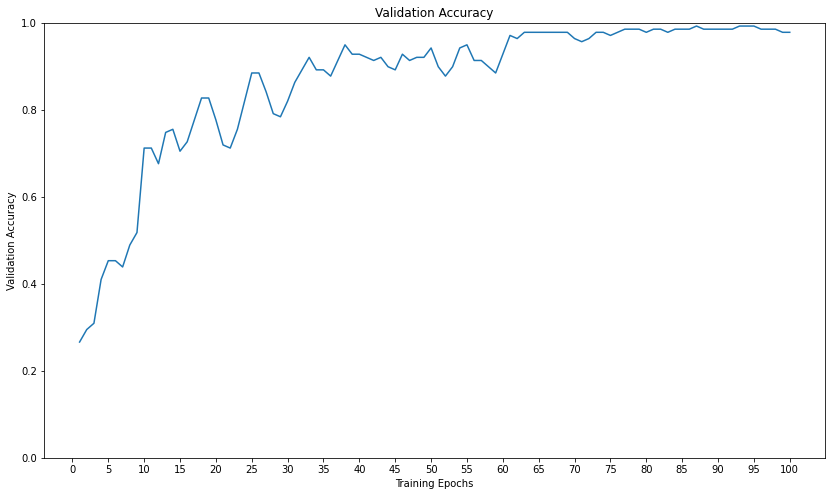

In [63]:
# val accuracy for only last fc layer unfreezed

# ohist = [h.cpu().numpy() for h in hist]

# plt.figure(figsize=(14, 8))
# plt.title("Validation Accuracy")
# plt.xlabel("Training Epochs")
# plt.ylabel("Validation Accuracy")
# plt.plot(range(1, num_epochs+1), ohist)
# plt.ylim((0,1.))
# plt.xticks(np.arange(0, num_epochs+1, 5.0))
# plt.show()

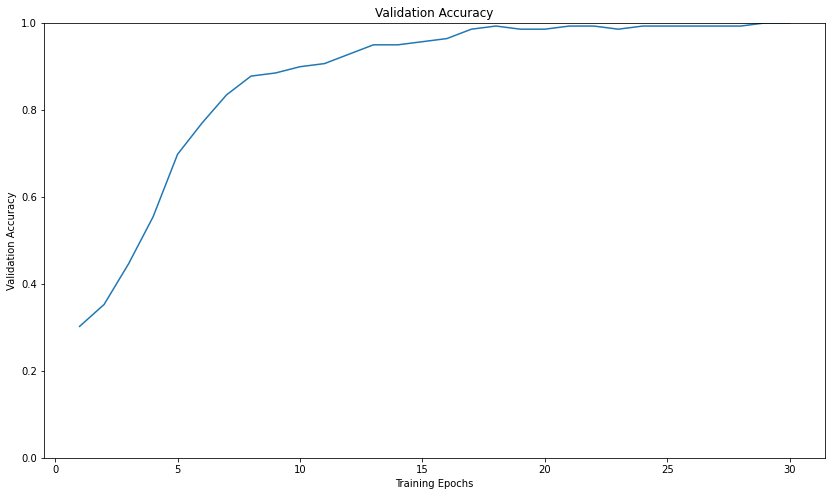

In [147]:
# val accuracy when last 5 layers unfreezed

ohist = [h.cpu().numpy() for h in hist]

plt.figure(figsize=(14, 8))
plt.title("Validation Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, num_epochs+1), ohist)
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs+1, 5.0))
plt.show()

In [111]:
seasons = {0 : "autumn",
           1 : "spring", 
           2 : "summer",
           3 : "winter"}

In [154]:
torch.save(model_ft, "./model.h5")

In [155]:
model_ft = torch.load("model.h5")

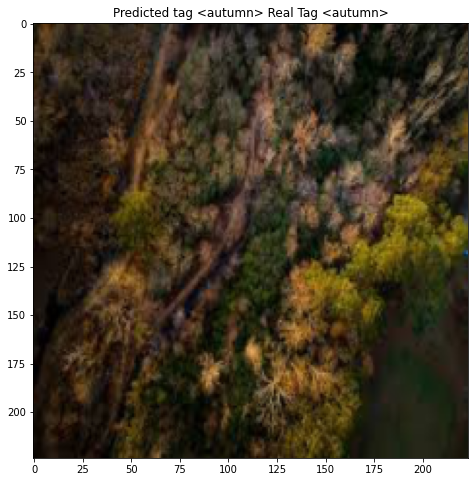

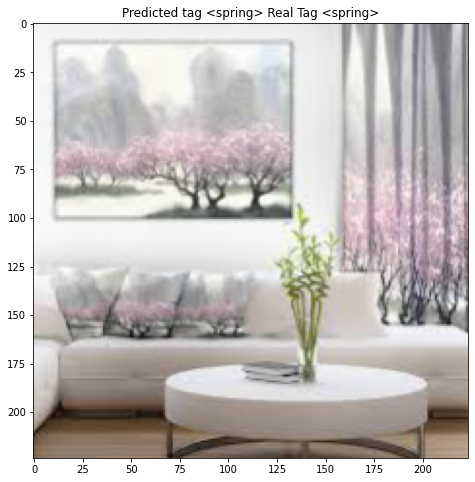

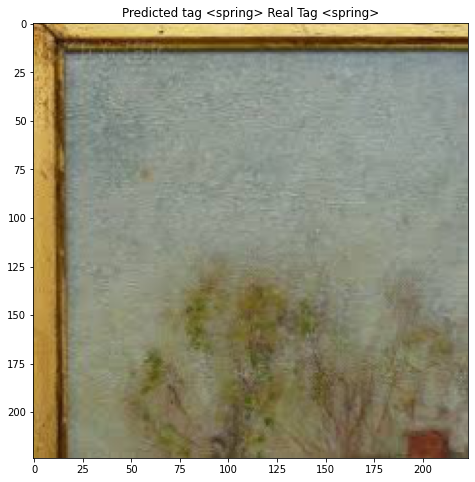

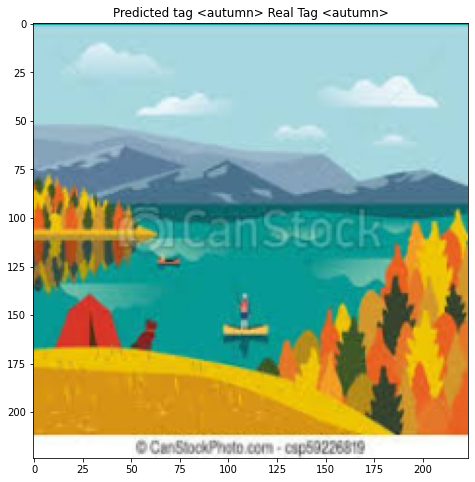

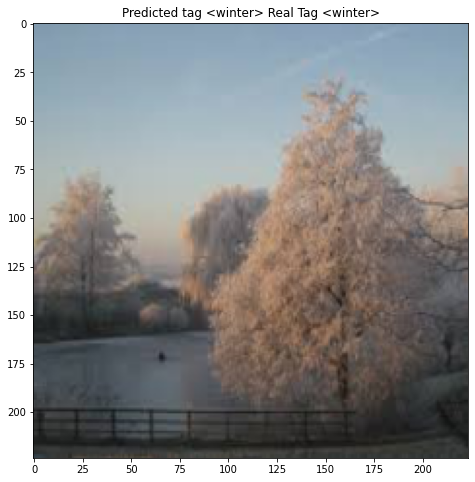

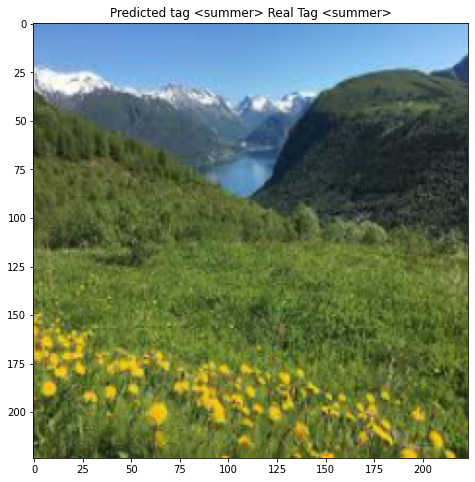

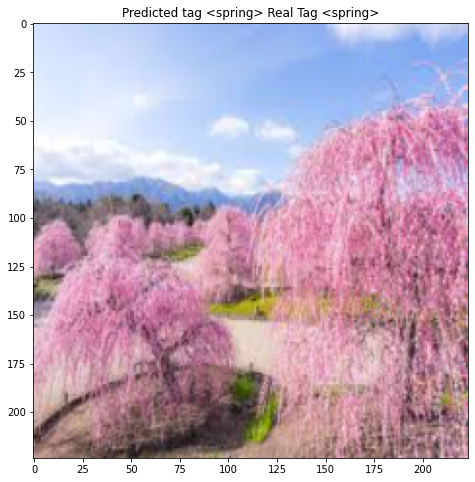

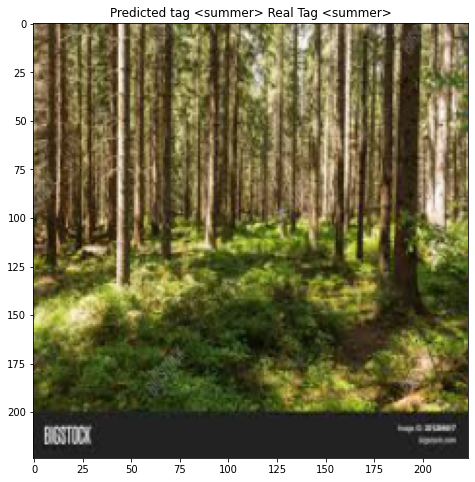

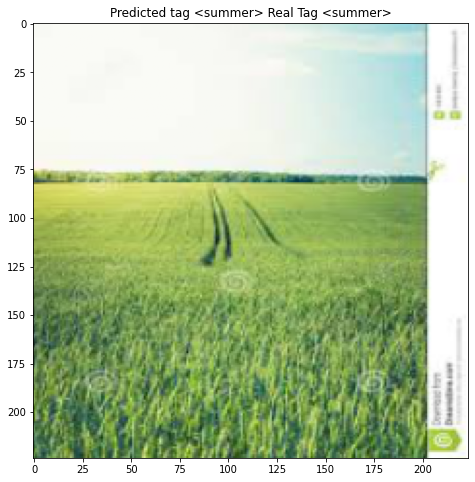

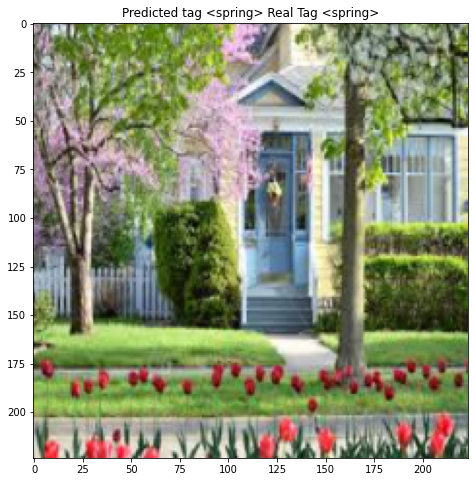

In [149]:
batch_x, batch_y = next(iter(test_data_loader))
batch_x = batch_x.to(device)
model_ft.eval()
preds = model_ft(batch_x)
_, pred = torch.max(preds, 1)
for i in range(10):
    plt.figure(figsize=(8,8))
    plt.title("Predicted tag <{}> Real Tag <{}>".format(seasons[pred[i].item()], seasons[batch_y[i].item()]))
    plt.imshow(np.transpose(batch_x[i].cpu(), [1,2,0]))

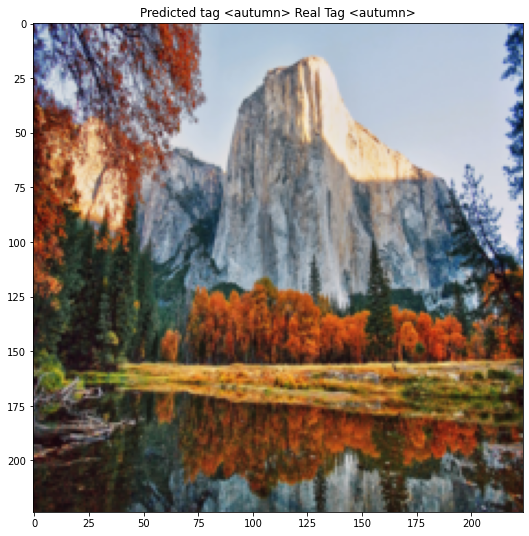

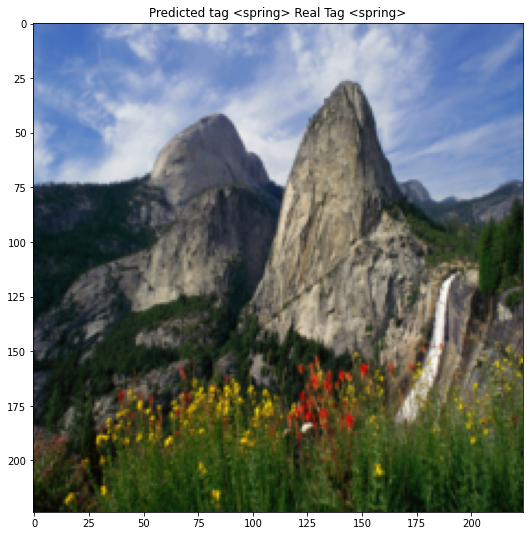

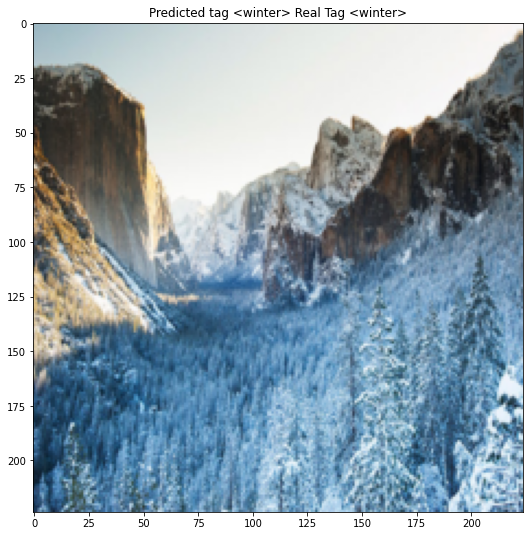

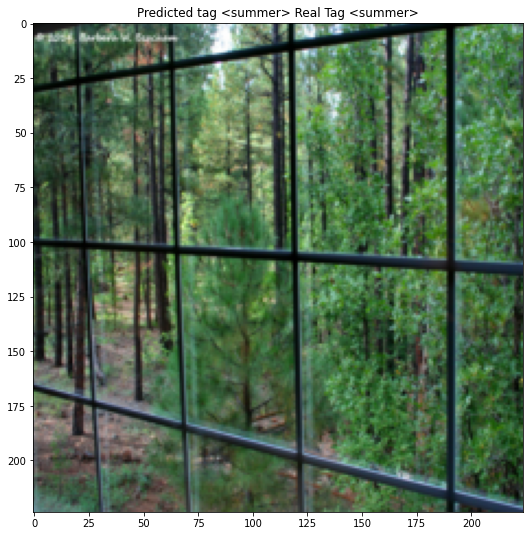

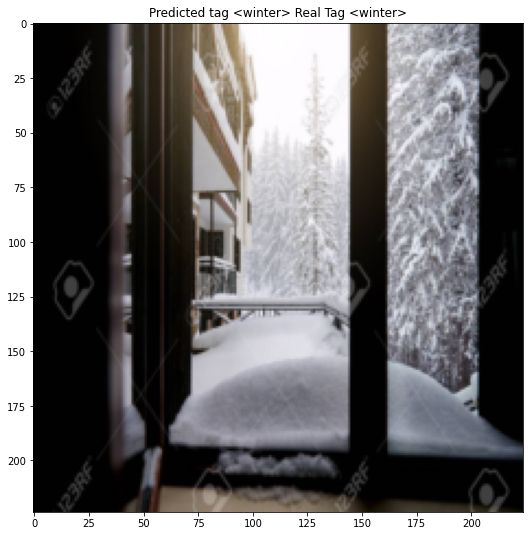

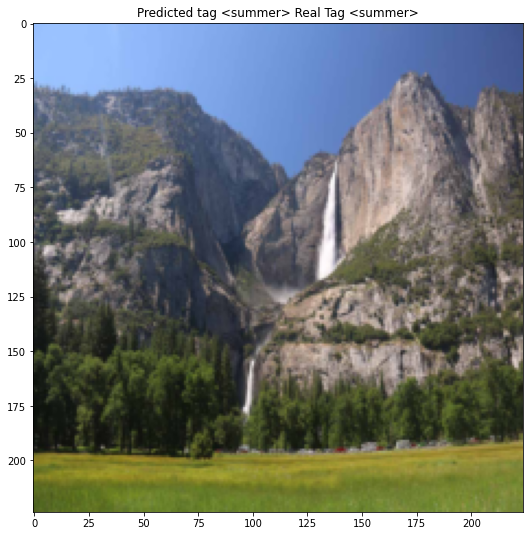

In [151]:
real_test_data_loader = get_data_loader('datasets/real_test/', 6, False)
batch_x, batch_y = next(iter(real_test_data_loader))
batch_x = batch_x.to(device)
model_ft.eval()
preds = model_ft(batch_x)
_, pred = torch.max(preds, 1)
for i in range(6):
    plt.figure(figsize=(9,9))
    plt.title("Predicted tag <{}> Real Tag <{}>".format(seasons[pred[i].item()], seasons[batch_y[i].item()]))
    plt.imshow(np.transpose(batch_x[i].cpu(), [1,2,0]))